In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
df1 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Dislike_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Like_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['value diff'] = data_df['item_value_1'] - data_df['item_value_0']
kbins = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='uniform')
data_df['value diff'] = kbins.fit_transform(data_df[['value diff']])
mms = MinMaxScaler(feature_range=(-5, 5))
data_df['Right Value - Left Value'] = mms.fit_transform(data_df[['value diff']])

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(7289, 5) (7289, 5)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + 0.1**14), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 111       
                                                                 
Total params: 479 (1.87 KB)
Trainable params: 479 (1.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 1s 1s/step - loss: 60036.6758
Epoch 2/3500
1/1 [==============================] - 0s 26ms/step - loss: 59728.0391
Epoch 3/3500
1/1 [==============================] - 0s 25ms/step - loss: 59498.8320
Epoch 4/3500
1/1 [==============================] - 0s 18ms/step - loss: 59301.8750
Epoch 5/3500
1/1 [==============================] - 0s 21ms/step - loss: 59123.1016
Epoch 6/3500
1/1 [==============================] - 0s 19ms/step - loss: 58956.3984
Epoch 7/3500
1/1 [==============================] - 0s 22ms/step - loss: 58798.4297
Epoch 8/3500
1/1 [==============================] - 0s 20ms/step - loss: 58647.1445
Epoch 9/3500
1/1 [==============================] - 0s 24ms/step - loss: 58501.1719
Epoch 10/3500
1/1 [==============================] - 0s 20ms/step - loss: 58359.5547
Epoch 11/3500
1/1 [==============================] - 0s 23ms/step - loss: 58221.5781
Epoch 12/3500
1/1 [==============================] - 0s 12ms/step - loss: 58

1/1 [==============================] - 0s 12ms/step - loss: 50438.7109
Epoch 98/3500
1/1 [==============================] - 0s 12ms/step - loss: 50383.3008
Epoch 99/3500
1/1 [==============================] - 0s 13ms/step - loss: 50328.4492
Epoch 100/3500
1/1 [==============================] - 0s 12ms/step - loss: 50274.1758
Epoch 101/3500
1/1 [==============================] - 0s 12ms/step - loss: 50220.4492
Epoch 102/3500
1/1 [==============================] - 0s 10ms/step - loss: 50167.2812
Epoch 103/3500
1/1 [==============================] - 0s 11ms/step - loss: 50114.6484
Epoch 104/3500
1/1 [==============================] - 0s 14ms/step - loss: 50062.5508
Epoch 105/3500
1/1 [==============================] - 0s 14ms/step - loss: 50010.9805
Epoch 106/3500
1/1 [==============================] - 0s 13ms/step - loss: 49959.9180
Epoch 107/3500
1/1 [==============================] - 0s 8ms/step - loss: 49909.3750
Epoch 108/3500
1/1 [==============================] - 0s 10ms/step - los

1/1 [==============================] - 0s 12ms/step - loss: 46833.0195
Epoch 193/3500
1/1 [==============================] - 0s 11ms/step - loss: 46805.9570
Epoch 194/3500
1/1 [==============================] - 0s 11ms/step - loss: 46779.0234
Epoch 195/3500
1/1 [==============================] - 0s 12ms/step - loss: 46752.2070
Epoch 196/3500
1/1 [==============================] - 0s 13ms/step - loss: 46725.5352
Epoch 197/3500
1/1 [==============================] - 0s 12ms/step - loss: 46698.9883
Epoch 198/3500
1/1 [==============================] - 0s 10ms/step - loss: 46672.5703
Epoch 199/3500
1/1 [==============================] - 0s 11ms/step - loss: 46646.2656
Epoch 200/3500
1/1 [==============================] - 0s 11ms/step - loss: 46620.0820
Epoch 201/3500
1/1 [==============================] - 0s 12ms/step - loss: 46594.0352
Epoch 202/3500
1/1 [==============================] - 0s 11ms/step - loss: 46568.1016
Epoch 203/3500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 9ms/step - loss: 44678.8281
Epoch 288/3500
1/1 [==============================] - 0s 9ms/step - loss: 44659.2930
Epoch 289/3500
1/1 [==============================] - 0s 8ms/step - loss: 44639.8086
Epoch 290/3500
1/1 [==============================] - 0s 9ms/step - loss: 44620.3633
Epoch 291/3500
1/1 [==============================] - 0s 8ms/step - loss: 44600.9609
Epoch 292/3500
1/1 [==============================] - 0s 10ms/step - loss: 44581.6016
Epoch 293/3500
1/1 [==============================] - 0s 10ms/step - loss: 44562.2930
Epoch 294/3500
1/1 [==============================] - 0s 12ms/step - loss: 44543.0234
Epoch 295/3500
1/1 [==============================] - 0s 11ms/step - loss: 44523.7969
Epoch 296/3500
1/1 [==============================] - 0s 12ms/step - loss: 44504.6172
Epoch 297/3500
1/1 [==============================] - 0s 12ms/step - loss: 44485.4805
Epoch 298/3500
1/1 [==============================] - 0s 12ms/step - loss:

1/1 [==============================] - 0s 14ms/step - loss: 42984.6680
Epoch 383/3500
1/1 [==============================] - 0s 13ms/step - loss: 42968.2422
Epoch 384/3500
1/1 [==============================] - 0s 16ms/step - loss: 42951.8359
Epoch 385/3500
1/1 [==============================] - 0s 13ms/step - loss: 42935.4492
Epoch 386/3500
1/1 [==============================] - 0s 9ms/step - loss: 42919.0938
Epoch 387/3500
1/1 [==============================] - 0s 9ms/step - loss: 42902.7578
Epoch 388/3500
1/1 [==============================] - 0s 9ms/step - loss: 42886.4453
Epoch 389/3500
1/1 [==============================] - 0s 9ms/step - loss: 42870.1602
Epoch 390/3500
1/1 [==============================] - 0s 9ms/step - loss: 42853.8906
Epoch 391/3500
1/1 [==============================] - 0s 9ms/step - loss: 42837.6562
Epoch 392/3500
1/1 [==============================] - 0s 9ms/step - loss: 42821.4336
Epoch 393/3500
1/1 [==============================] - 0s 9ms/step - loss: 42

1/1 [==============================] - 0s 9ms/step - loss: 41505.2148
Epoch 479/3500
1/1 [==============================] - 0s 10ms/step - loss: 41490.7578
Epoch 480/3500
1/1 [==============================] - 0s 9ms/step - loss: 41476.3086
Epoch 481/3500
1/1 [==============================] - 0s 9ms/step - loss: 41461.8789
Epoch 482/3500
1/1 [==============================] - 0s 9ms/step - loss: 41447.4688
Epoch 483/3500
1/1 [==============================] - 0s 9ms/step - loss: 41433.0781
Epoch 484/3500
1/1 [==============================] - 0s 9ms/step - loss: 41418.6992
Epoch 485/3500
1/1 [==============================] - 0s 9ms/step - loss: 41404.3438
Epoch 486/3500
1/1 [==============================] - 0s 8ms/step - loss: 41390.0078
Epoch 487/3500
1/1 [==============================] - 0s 9ms/step - loss: 41375.6875
Epoch 488/3500
1/1 [==============================] - 0s 11ms/step - loss: 41361.3750
Epoch 489/3500
1/1 [==============================] - 0s 11ms/step - loss: 413

1/1 [==============================] - 0s 17ms/step - loss: 40192.5547
Epoch 574/3500
1/1 [==============================] - 0s 16ms/step - loss: 40179.2812
Epoch 575/3500
1/1 [==============================] - 0s 19ms/step - loss: 40165.9688
Epoch 576/3500
1/1 [==============================] - 0s 17ms/step - loss: 40152.7070
Epoch 577/3500
1/1 [==============================] - 0s 23ms/step - loss: 40139.4219
Epoch 578/3500
1/1 [==============================] - 0s 22ms/step - loss: 40126.1719
Epoch 579/3500
1/1 [==============================] - 0s 24ms/step - loss: 40112.8984
Epoch 580/3500
1/1 [==============================] - 0s 16ms/step - loss: 40099.6719
Epoch 581/3500
1/1 [==============================] - 0s 9ms/step - loss: 40086.4180
Epoch 582/3500
1/1 [==============================] - 0s 10ms/step - loss: 40073.2070
Epoch 583/3500
1/1 [==============================] - 0s 10ms/step - loss: 40059.9688
Epoch 584/3500
1/1 [==============================] - 0s 10ms/step - l

1/1 [==============================] - 0s 12ms/step - loss: 38958.7305
Epoch 669/3500
1/1 [==============================] - 0s 10ms/step - loss: 38945.9219
Epoch 670/3500
1/1 [==============================] - 0s 10ms/step - loss: 38933.1133
Epoch 671/3500
1/1 [==============================] - 0s 10ms/step - loss: 38920.2969
Epoch 672/3500
1/1 [==============================] - 0s 10ms/step - loss: 38907.4844
Epoch 673/3500
1/1 [==============================] - 0s 10ms/step - loss: 38894.6641
Epoch 674/3500
1/1 [==============================] - 0s 10ms/step - loss: 38881.8438
Epoch 675/3500
1/1 [==============================] - 0s 10ms/step - loss: 38869.0234
Epoch 676/3500
1/1 [==============================] - 0s 10ms/step - loss: 38856.1953
Epoch 677/3500
1/1 [==============================] - 0s 26ms/step - loss: 38843.3594
Epoch 678/3500
1/1 [==============================] - 0s 23ms/step - loss: 38830.5234
Epoch 679/3500
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 20ms/step - loss: 37743.6016
Epoch 764/3500
1/1 [==============================] - 0s 14ms/step - loss: 37730.1719
Epoch 765/3500
1/1 [==============================] - 0s 11ms/step - loss: 37716.6758
Epoch 766/3500
1/1 [==============================] - 0s 11ms/step - loss: 37703.1328
Epoch 767/3500
1/1 [==============================] - 0s 10ms/step - loss: 37689.5117
Epoch 768/3500
1/1 [==============================] - 0s 9ms/step - loss: 37675.8359
Epoch 769/3500
1/1 [==============================] - 0s 10ms/step - loss: 37662.0938
Epoch 770/3500
1/1 [==============================] - 0s 15ms/step - loss: 37648.2969
Epoch 771/3500
1/1 [==============================] - 0s 12ms/step - loss: 37634.4453
Epoch 772/3500
1/1 [==============================] - 0s 12ms/step - loss: 37620.5195
Epoch 773/3500
1/1 [==============================] - 0s 16ms/step - loss: 37606.5430
Epoch 774/3500
1/1 [==============================] - 0s 24ms/step - l

1/1 [==============================] - 0s 16ms/step - loss: 35984.5703
Epoch 859/3500
1/1 [==============================] - 0s 14ms/step - loss: 35964.1602
Epoch 860/3500
1/1 [==============================] - 0s 13ms/step - loss: 35943.8672
Epoch 861/3500
1/1 [==============================] - 0s 11ms/step - loss: 35923.6875
Epoch 862/3500
1/1 [==============================] - 0s 11ms/step - loss: 35903.5898
Epoch 863/3500
1/1 [==============================] - 0s 15ms/step - loss: 35883.5625
Epoch 864/3500
1/1 [==============================] - 0s 11ms/step - loss: 35863.5938
Epoch 865/3500
1/1 [==============================] - 0s 13ms/step - loss: 35843.6641
Epoch 866/3500
1/1 [==============================] - 0s 15ms/step - loss: 35823.7812
Epoch 867/3500
1/1 [==============================] - 0s 14ms/step - loss: 35803.9102
Epoch 868/3500
1/1 [==============================] - 0s 15ms/step - loss: 35784.0469
Epoch 869/3500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 21ms/step - loss: 34180.0430
Epoch 954/3500
1/1 [==============================] - 0s 20ms/step - loss: 34164.7656
Epoch 955/3500
1/1 [==============================] - 0s 18ms/step - loss: 34149.5078
Epoch 956/3500
1/1 [==============================] - 0s 16ms/step - loss: 34134.3711
Epoch 957/3500
1/1 [==============================] - 0s 17ms/step - loss: 34119.2422
Epoch 958/3500
1/1 [==============================] - 0s 13ms/step - loss: 34104.2305
Epoch 959/3500
1/1 [==============================] - 0s 10ms/step - loss: 34089.2266
Epoch 960/3500
1/1 [==============================] - 0s 13ms/step - loss: 34074.3359
Epoch 961/3500
1/1 [==============================] - 0s 14ms/step - loss: 34059.4453
Epoch 962/3500
1/1 [==============================] - 0s 14ms/step - loss: 34044.6641
Epoch 963/3500
1/1 [==============================] - 0s 12ms/step - loss: 34029.8828
Epoch 964/3500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 14ms/step - loss: 32862.7695
Epoch 1049/3500
1/1 [==============================] - 0s 13ms/step - loss: 32849.4258
Epoch 1050/3500
1/1 [==============================] - 0s 11ms/step - loss: 32836.1719
Epoch 1051/3500
1/1 [==============================] - 0s 11ms/step - loss: 32822.8359
Epoch 1052/3500
1/1 [==============================] - 0s 12ms/step - loss: 32809.5781
Epoch 1053/3500
1/1 [==============================] - 0s 12ms/step - loss: 32796.2500
Epoch 1054/3500
1/1 [==============================] - 0s 11ms/step - loss: 32782.9961
Epoch 1055/3500
1/1 [==============================] - 0s 12ms/step - loss: 32769.6641
Epoch 1056/3500
1/1 [==============================] - 0s 13ms/step - loss: 32756.3945
Epoch 1057/3500
1/1 [==============================] - 0s 11ms/step - loss: 32743.0684
Epoch 1058/3500
1/1 [==============================] - 0s 12ms/step - loss: 32729.8105
Epoch 1059/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 12ms/step - loss: 31668.1504
Epoch 1143/3500
1/1 [==============================] - 0s 14ms/step - loss: 31656.5059
Epoch 1144/3500
1/1 [==============================] - 0s 22ms/step - loss: 31645.0195
Epoch 1145/3500
1/1 [==============================] - 0s 14ms/step - loss: 31633.5176
Epoch 1146/3500
1/1 [==============================] - 0s 11ms/step - loss: 31621.9434
Epoch 1147/3500
1/1 [==============================] - 0s 13ms/step - loss: 31610.2188
Epoch 1148/3500
1/1 [==============================] - 0s 14ms/step - loss: 31598.4883
Epoch 1149/3500
1/1 [==============================] - 0s 13ms/step - loss: 31586.7988
Epoch 1150/3500
1/1 [==============================] - 0s 11ms/step - loss: 31575.2422
Epoch 1151/3500
1/1 [==============================] - 0s 10ms/step - loss: 31563.7500
Epoch 1152/3500
1/1 [==============================] - 0s 11ms/step - loss: 31552.4102
Epoch 1153/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 8ms/step - loss: 30699.6562
Epoch 1237/3500
1/1 [==============================] - 0s 9ms/step - loss: 30690.4609
Epoch 1238/3500
1/1 [==============================] - 0s 9ms/step - loss: 30681.2129
Epoch 1239/3500
1/1 [==============================] - 0s 9ms/step - loss: 30671.4844
Epoch 1240/3500
1/1 [==============================] - 0s 9ms/step - loss: 30661.9258
Epoch 1241/3500
1/1 [==============================] - 0s 9ms/step - loss: 30652.2852
Epoch 1242/3500
1/1 [==============================] - 0s 10ms/step - loss: 30642.8770
Epoch 1243/3500
1/1 [==============================] - 0s 9ms/step - loss: 30633.4980
Epoch 1244/3500
1/1 [==============================] - 0s 8ms/step - loss: 30624.2773
Epoch 1245/3500
1/1 [==============================] - 0s 9ms/step - loss: 30615.0938
Epoch 1246/3500
1/1 [==============================] - 0s 8ms/step - loss: 30605.9805
Epoch 1247/3500
1/1 [==============================] - 0s 9ms/step - 

1/1 [==============================] - 0s 12ms/step - loss: 29947.3164
Epoch 1331/3500
1/1 [==============================] - 0s 15ms/step - loss: 29940.5254
Epoch 1332/3500
1/1 [==============================] - 0s 14ms/step - loss: 29933.7246
Epoch 1333/3500
1/1 [==============================] - 0s 13ms/step - loss: 29927.0469
Epoch 1334/3500
1/1 [==============================] - 0s 12ms/step - loss: 29920.4883
Epoch 1335/3500
1/1 [==============================] - 0s 14ms/step - loss: 29914.0625
Epoch 1336/3500
1/1 [==============================] - 0s 14ms/step - loss: 29907.8203
Epoch 1337/3500
1/1 [==============================] - 0s 15ms/step - loss: 29901.6680
Epoch 1338/3500
1/1 [==============================] - 0s 13ms/step - loss: 29895.6777
Epoch 1339/3500
1/1 [==============================] - 0s 14ms/step - loss: 29889.3574
Epoch 1340/3500
1/1 [==============================] - 0s 16ms/step - loss: 29882.9375
Epoch 1341/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 15ms/step - loss: 29420.8242
Epoch 1425/3500
1/1 [==============================] - 0s 14ms/step - loss: 29416.2109
Epoch 1426/3500
1/1 [==============================] - 0s 11ms/step - loss: 29411.8047
Epoch 1427/3500
1/1 [==============================] - 0s 10ms/step - loss: 29407.5117
Epoch 1428/3500
1/1 [==============================] - 0s 10ms/step - loss: 29403.1211
Epoch 1429/3500
1/1 [==============================] - 0s 10ms/step - loss: 29398.5508
Epoch 1430/3500
1/1 [==============================] - 0s 9ms/step - loss: 29393.6250
Epoch 1431/3500
1/1 [==============================] - 0s 10ms/step - loss: 29388.7168
Epoch 1432/3500
1/1 [==============================] - 0s 10ms/step - loss: 29383.7734
Epoch 1433/3500
1/1 [==============================] - 0s 8ms/step - loss: 29379.0156
Epoch 1434/3500
1/1 [==============================] - 0s 9ms/step - loss: 29374.3867
Epoch 1435/3500
1/1 [==============================] - 0s 9ms/

1/1 [==============================] - 0s 25ms/step - loss: 29038.5664
Epoch 1519/3500
1/1 [==============================] - 0s 17ms/step - loss: 29034.8145
Epoch 1520/3500
1/1 [==============================] - 0s 16ms/step - loss: 29030.9219
Epoch 1521/3500
1/1 [==============================] - 0s 18ms/step - loss: 29026.8867
Epoch 1522/3500
1/1 [==============================] - 0s 16ms/step - loss: 29023.0918
Epoch 1523/3500
1/1 [==============================] - 0s 18ms/step - loss: 29019.4316
Epoch 1524/3500
1/1 [==============================] - 0s 22ms/step - loss: 29016.0430
Epoch 1525/3500
1/1 [==============================] - 0s 15ms/step - loss: 29012.8555
Epoch 1526/3500
1/1 [==============================] - 0s 21ms/step - loss: 29009.7695
Epoch 1527/3500
1/1 [==============================] - 0s 15ms/step - loss: 29006.7266
Epoch 1528/3500
1/1 [==============================] - 0s 30ms/step - loss: 29003.3301
Epoch 1529/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 13ms/step - loss: 28736.9062
Epoch 1613/3500
1/1 [==============================] - 0s 17ms/step - loss: 28734.0000
Epoch 1614/3500
1/1 [==============================] - 0s 13ms/step - loss: 28731.2637
Epoch 1615/3500
1/1 [==============================] - 0s 13ms/step - loss: 28728.6973
Epoch 1616/3500
1/1 [==============================] - 0s 13ms/step - loss: 28726.2969
Epoch 1617/3500
1/1 [==============================] - 0s 13ms/step - loss: 28723.7266
Epoch 1618/3500
1/1 [==============================] - 0s 12ms/step - loss: 28720.8984
Epoch 1619/3500
1/1 [==============================] - 0s 13ms/step - loss: 28717.5430
Epoch 1620/3500
1/1 [==============================] - 0s 13ms/step - loss: 28714.2363
Epoch 1621/3500
1/1 [==============================] - 0s 11ms/step - loss: 28710.9258
Epoch 1622/3500
1/1 [==============================] - 0s 12ms/step - loss: 28707.9453
Epoch 1623/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 9ms/step - loss: 28478.6816
Epoch 1707/3500
1/1 [==============================] - 0s 9ms/step - loss: 28476.3789
Epoch 1708/3500
1/1 [==============================] - 0s 9ms/step - loss: 28473.7285
Epoch 1709/3500
1/1 [==============================] - 0s 11ms/step - loss: 28470.7520
Epoch 1710/3500
1/1 [==============================] - 0s 12ms/step - loss: 28467.6875
Epoch 1711/3500
1/1 [==============================] - 0s 12ms/step - loss: 28464.7051
Epoch 1712/3500
1/1 [==============================] - 0s 12ms/step - loss: 28461.9219
Epoch 1713/3500
1/1 [==============================] - 0s 11ms/step - loss: 28459.2910
Epoch 1714/3500
1/1 [==============================] - 0s 10ms/step - loss: 28456.9102
Epoch 1715/3500
1/1 [==============================] - 0s 10ms/step - loss: 28454.5430
Epoch 1716/3500
1/1 [==============================] - 0s 10ms/step - loss: 28452.3906
Epoch 1717/3500
1/1 [==============================] - 0s 10ms

1/1 [==============================] - 0s 16ms/step - loss: 28244.9961
Epoch 1801/3500
1/1 [==============================] - 0s 17ms/step - loss: 28242.9414
Epoch 1802/3500
1/1 [==============================] - 0s 18ms/step - loss: 28241.1230
Epoch 1803/3500
1/1 [==============================] - 0s 19ms/step - loss: 28238.5234
Epoch 1804/3500
1/1 [==============================] - 0s 17ms/step - loss: 28236.2227
Epoch 1805/3500
1/1 [==============================] - 0s 20ms/step - loss: 28233.2422
Epoch 1806/3500
1/1 [==============================] - 0s 21ms/step - loss: 28230.9473
Epoch 1807/3500
1/1 [==============================] - 0s 16ms/step - loss: 28228.4551
Epoch 1808/3500
1/1 [==============================] - 0s 18ms/step - loss: 28226.4453
Epoch 1809/3500
1/1 [==============================] - 0s 16ms/step - loss: 28224.3438
Epoch 1810/3500
1/1 [==============================] - 0s 16ms/step - loss: 28222.4375
Epoch 1811/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 14ms/step - loss: 28042.8047
Epoch 1895/3500
1/1 [==============================] - 0s 16ms/step - loss: 28040.7031
Epoch 1896/3500
1/1 [==============================] - 0s 12ms/step - loss: 28038.9766
Epoch 1897/3500
1/1 [==============================] - 0s 10ms/step - loss: 28036.9375
Epoch 1898/3500
1/1 [==============================] - 0s 9ms/step - loss: 28035.1055
Epoch 1899/3500
1/1 [==============================] - 0s 9ms/step - loss: 28032.8867
Epoch 1900/3500
1/1 [==============================] - 0s 9ms/step - loss: 28030.9219
Epoch 1901/3500
1/1 [==============================] - 0s 9ms/step - loss: 28028.6230
Epoch 1902/3500
1/1 [==============================] - 0s 9ms/step - loss: 28026.7090
Epoch 1903/3500
1/1 [==============================] - 0s 10ms/step - loss: 28024.5332
Epoch 1904/3500
1/1 [==============================] - 0s 10ms/step - loss: 28022.8711
Epoch 1905/3500
1/1 [==============================] - 0s 11ms/s

1/1 [==============================] - 0s 12ms/step - loss: 27864.7109
Epoch 1989/3500
1/1 [==============================] - 0s 13ms/step - loss: 27862.5098
Epoch 1990/3500
1/1 [==============================] - 0s 11ms/step - loss: 27860.9375
Epoch 1991/3500
1/1 [==============================] - 0s 12ms/step - loss: 27858.8555
Epoch 1992/3500
1/1 [==============================] - 0s 13ms/step - loss: 27857.3887
Epoch 1993/3500
1/1 [==============================] - 0s 10ms/step - loss: 27855.4727
Epoch 1994/3500
1/1 [==============================] - 0s 25ms/step - loss: 27854.0156
Epoch 1995/3500
1/1 [==============================] - 0s 15ms/step - loss: 27852.0586
Epoch 1996/3500
1/1 [==============================] - 0s 13ms/step - loss: 27850.5000
Epoch 1997/3500
1/1 [==============================] - 0s 12ms/step - loss: 27848.4199
Epoch 1998/3500
1/1 [==============================] - 0s 13ms/step - loss: 27846.8320
Epoch 1999/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 9ms/step - loss: 27709.0176
Epoch 2083/3500
1/1 [==============================] - 0s 9ms/step - loss: 27707.0625
Epoch 2084/3500
1/1 [==============================] - 0s 10ms/step - loss: 27705.8164
Epoch 2085/3500
1/1 [==============================] - 0s 8ms/step - loss: 27703.9805
Epoch 2086/3500
1/1 [==============================] - 0s 8ms/step - loss: 27702.7969
Epoch 2087/3500
1/1 [==============================] - 0s 9ms/step - loss: 27701.0215
Epoch 2088/3500
1/1 [==============================] - 0s 9ms/step - loss: 27699.8477
Epoch 2089/3500
1/1 [==============================] - 0s 9ms/step - loss: 27698.0273
Epoch 2090/3500
1/1 [==============================] - 0s 9ms/step - loss: 27696.7734
Epoch 2091/3500
1/1 [==============================] - 0s 10ms/step - loss: 27694.8633
Epoch 2092/3500
1/1 [==============================] - 0s 16ms/step - loss: 27693.5938
Epoch 2093/3500
1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 21ms/step - loss: 27572.4766
Epoch 2177/3500
1/1 [==============================] - 0s 11ms/step - loss: 27570.6641
Epoch 2178/3500
1/1 [==============================] - 0s 13ms/step - loss: 27569.6719
Epoch 2179/3500
1/1 [==============================] - 0s 10ms/step - loss: 27567.8379
Epoch 2180/3500
1/1 [==============================] - 0s 12ms/step - loss: 27566.8379
Epoch 2181/3500
1/1 [==============================] - 0s 11ms/step - loss: 27565.1152
Epoch 2182/3500
1/1 [==============================] - 0s 9ms/step - loss: 27564.2070
Epoch 2183/3500
1/1 [==============================] - 0s 12ms/step - loss: 27562.5176
Epoch 2184/3500
1/1 [==============================] - 0s 10ms/step - loss: 27561.5684
Epoch 2185/3500
1/1 [==============================] - 0s 10ms/step - loss: 27559.8770
Epoch 2186/3500
1/1 [==============================] - 0s 12ms/step - loss: 27558.8457
Epoch 2187/3500
1/1 [==============================] - 0s 17

1/1 [==============================] - 0s 11ms/step - loss: 27453.0938
Epoch 2271/3500
1/1 [==============================] - 0s 10ms/step - loss: 27451.4121
Epoch 2272/3500
1/1 [==============================] - 0s 10ms/step - loss: 27450.8125
Epoch 2273/3500
1/1 [==============================] - 0s 11ms/step - loss: 27449.0586
Epoch 2274/3500
1/1 [==============================] - 0s 10ms/step - loss: 27448.3281
Epoch 2275/3500
1/1 [==============================] - 0s 16ms/step - loss: 27446.5586
Epoch 2276/3500
1/1 [==============================] - 0s 23ms/step - loss: 27445.8711
Epoch 2277/3500
1/1 [==============================] - 0s 25ms/step - loss: 27444.2539
Epoch 2278/3500
1/1 [==============================] - 0s 22ms/step - loss: 27443.7363
Epoch 2279/3500
1/1 [==============================] - 0s 20ms/step - loss: 27442.2402
Epoch 2280/3500
1/1 [==============================] - 0s 15ms/step - loss: 27441.6641
Epoch 2281/3500
1/1 [==============================] - 0s 9

1/1 [==============================] - 0s 11ms/step - loss: 27352.5508
Epoch 2365/3500
1/1 [==============================] - 0s 10ms/step - loss: 27350.9961
Epoch 2366/3500
1/1 [==============================] - 0s 10ms/step - loss: 27350.7344
Epoch 2367/3500
1/1 [==============================] - 0s 10ms/step - loss: 27349.2656
Epoch 2368/3500
1/1 [==============================] - 0s 10ms/step - loss: 27348.9492
Epoch 2369/3500
1/1 [==============================] - 0s 10ms/step - loss: 27347.4492
Epoch 2370/3500
1/1 [==============================] - 0s 14ms/step - loss: 27347.1289
Epoch 2371/3500
1/1 [==============================] - 0s 11ms/step - loss: 27345.5820
Epoch 2372/3500
1/1 [==============================] - 0s 13ms/step - loss: 27345.2832
Epoch 2373/3500
1/1 [==============================] - 0s 10ms/step - loss: 27343.7949
Epoch 2374/3500
1/1 [==============================] - 0s 12ms/step - loss: 27343.3398
Epoch 2375/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 9ms/step - loss: 27266.4883
Epoch 2459/3500
1/1 [==============================] - 0s 10ms/step - loss: 27265.5547
Epoch 2460/3500
1/1 [==============================] - 0s 9ms/step - loss: 27265.5938
Epoch 2461/3500
1/1 [==============================] - 0s 10ms/step - loss: 27264.0957
Epoch 2462/3500
1/1 [==============================] - 0s 17ms/step - loss: 27263.8438
Epoch 2463/3500
1/1 [==============================] - 0s 17ms/step - loss: 27262.5703
Epoch 2464/3500
1/1 [==============================] - 0s 15ms/step - loss: 27262.3594
Epoch 2465/3500
1/1 [==============================] - 0s 18ms/step - loss: 27260.5469
Epoch 2466/3500
1/1 [==============================] - 0s 14ms/step - loss: 27260.1660
Epoch 2467/3500
1/1 [==============================] - 0s 17ms/step - loss: 27258.6719
Epoch 2468/3500
1/1 [==============================] - 0s 15ms/step - loss: 27258.1836
Epoch 2469/3500
1/1 [==============================] - 0s 15m

1/1 [==============================] - 0s 10ms/step - loss: 27191.5352
Epoch 2553/3500
1/1 [==============================] - 0s 10ms/step - loss: 27190.4746
Epoch 2554/3500
1/1 [==============================] - 0s 9ms/step - loss: 27190.5156
Epoch 2555/3500
1/1 [==============================] - 0s 10ms/step - loss: 27189.1523
Epoch 2556/3500
1/1 [==============================] - 0s 9ms/step - loss: 27189.4824
Epoch 2557/3500
1/1 [==============================] - 0s 9ms/step - loss: 27187.7793
Epoch 2558/3500
1/1 [==============================] - 0s 9ms/step - loss: 27187.6934
Epoch 2559/3500
1/1 [==============================] - 0s 9ms/step - loss: 27186.2148
Epoch 2560/3500
1/1 [==============================] - 0s 10ms/step - loss: 27186.3594
Epoch 2561/3500
1/1 [==============================] - 0s 10ms/step - loss: 27185.0527
Epoch 2562/3500
1/1 [==============================] - 0s 10ms/step - loss: 27185.0625
Epoch 2563/3500
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 14ms/step - loss: 27130.1484
Epoch 2647/3500
1/1 [==============================] - 0s 13ms/step - loss: 27128.8359
Epoch 2648/3500
1/1 [==============================] - 0s 13ms/step - loss: 27128.9688
Epoch 2649/3500
1/1 [==============================] - 0s 10ms/step - loss: 27127.6152
Epoch 2650/3500
1/1 [==============================] - 0s 11ms/step - loss: 27127.8984
Epoch 2651/3500
1/1 [==============================] - 0s 12ms/step - loss: 27126.8516
Epoch 2652/3500
1/1 [==============================] - 0s 11ms/step - loss: 27126.9336
Epoch 2653/3500
1/1 [==============================] - 0s 12ms/step - loss: 27125.7988
Epoch 2654/3500
1/1 [==============================] - 0s 10ms/step - loss: 27125.8789
Epoch 2655/3500
1/1 [==============================] - 0s 11ms/step - loss: 27124.3652
Epoch 2656/3500
1/1 [==============================] - 0s 10ms/step - loss: 27124.5234
Epoch 2657/3500
1/1 [==============================] - 0s 9

1/1 [==============================] - 0s 12ms/step - loss: 27079.7324
Epoch 2741/3500
1/1 [==============================] - 0s 13ms/step - loss: 27078.2539
Epoch 2742/3500
1/1 [==============================] - 0s 11ms/step - loss: 27078.3047
Epoch 2743/3500
1/1 [==============================] - 0s 11ms/step - loss: 27077.0391
Epoch 2744/3500
1/1 [==============================] - 0s 10ms/step - loss: 27077.2266
Epoch 2745/3500
1/1 [==============================] - 0s 9ms/step - loss: 27076.3086
Epoch 2746/3500
1/1 [==============================] - 0s 10ms/step - loss: 27076.7539
Epoch 2747/3500
1/1 [==============================] - 0s 10ms/step - loss: 27076.6953
Epoch 2748/3500
1/1 [==============================] - 0s 10ms/step - loss: 27077.2598
Epoch 2749/3500
1/1 [==============================] - 0s 10ms/step - loss: 27074.9648
Epoch 2750/3500
1/1 [==============================] - 0s 10ms/step - loss: 27074.7324
Epoch 2751/3500
1/1 [==============================] - 0s 15

1/1 [==============================] - 0s 13ms/step - loss: 27037.4434
Epoch 2835/3500
1/1 [==============================] - 0s 12ms/step - loss: 27035.9805
Epoch 2836/3500
1/1 [==============================] - 0s 16ms/step - loss: 27036.3184
Epoch 2837/3500
1/1 [==============================] - 0s 13ms/step - loss: 27034.6367
Epoch 2838/3500
1/1 [==============================] - 0s 21ms/step - loss: 27034.5078
Epoch 2839/3500
1/1 [==============================] - 0s 15ms/step - loss: 27033.5117
Epoch 2840/3500
1/1 [==============================] - 0s 14ms/step - loss: 27033.9375
Epoch 2841/3500
1/1 [==============================] - 0s 16ms/step - loss: 27033.0762
Epoch 2842/3500
1/1 [==============================] - 0s 20ms/step - loss: 27033.8711
Epoch 2843/3500
1/1 [==============================] - 0s 13ms/step - loss: 27033.1504
Epoch 2844/3500
1/1 [==============================] - 0s 14ms/step - loss: 27034.2305
Epoch 2845/3500
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 27ms/step - loss: 26999.9688
Epoch 2929/3500
1/1 [==============================] - 0s 11ms/step - loss: 26998.1680
Epoch 2930/3500
1/1 [==============================] - 0s 10ms/step - loss: 26999.1367
Epoch 2931/3500
1/1 [==============================] - 0s 12ms/step - loss: 26998.5742
Epoch 2932/3500
1/1 [==============================] - 0s 10ms/step - loss: 26999.8691
Epoch 2933/3500
1/1 [==============================] - 0s 10ms/step - loss: 26999.3457
Epoch 2934/3500
1/1 [==============================] - 0s 10ms/step - loss: 27000.9531
Epoch 2935/3500
1/1 [==============================] - 0s 10ms/step - loss: 26998.4785
Epoch 2936/3500
1/1 [==============================] - 0s 10ms/step - loss: 26997.9297
Epoch 2937/3500
1/1 [==============================] - 0s 11ms/step - loss: 26995.8047
Epoch 2938/3500
1/1 [==============================] - 0s 9ms/step - loss: 26995.6777
Epoch 2939/3500
1/1 [==============================] - 0s 11

1/1 [==============================] - 0s 9ms/step - loss: 26972.5684
Epoch 3023/3500
1/1 [==============================] - 0s 9ms/step - loss: 26969.0469
Epoch 3024/3500
1/1 [==============================] - 0s 9ms/step - loss: 26968.7383
Epoch 3025/3500
1/1 [==============================] - 0s 9ms/step - loss: 26965.6016
Epoch 3026/3500
1/1 [==============================] - 0s 9ms/step - loss: 26965.5117
Epoch 3027/3500
1/1 [==============================] - 0s 9ms/step - loss: 26964.7598
Epoch 3028/3500
1/1 [==============================] - 0s 9ms/step - loss: 26966.0039
Epoch 3029/3500
1/1 [==============================] - 0s 10ms/step - loss: 26964.3516
Epoch 3030/3500
1/1 [==============================] - 0s 12ms/step - loss: 26965.5996
Epoch 3031/3500
1/1 [==============================] - 0s 11ms/step - loss: 26965.0742
Epoch 3032/3500
1/1 [==============================] - 0s 10ms/step - loss: 26967.4570
Epoch 3033/3500
1/1 [==============================] - 0s 9ms/step

1/1 [==============================] - 0s 15ms/step - loss: 26941.8340
Epoch 3117/3500
1/1 [==============================] - 0s 16ms/step - loss: 26938.8867
Epoch 3118/3500
1/1 [==============================] - 0s 15ms/step - loss: 26939.4805
Epoch 3119/3500
1/1 [==============================] - 0s 15ms/step - loss: 26938.9883
Epoch 3120/3500
1/1 [==============================] - 0s 14ms/step - loss: 26940.4453
Epoch 3121/3500
1/1 [==============================] - 0s 16ms/step - loss: 26938.8125
Epoch 3122/3500
1/1 [==============================] - 0s 14ms/step - loss: 26940.2227
Epoch 3123/3500
1/1 [==============================] - 0s 9ms/step - loss: 26938.4844
Epoch 3124/3500
1/1 [==============================] - 0s 9ms/step - loss: 26940.2383
Epoch 3125/3500
1/1 [==============================] - 0s 9ms/step - loss: 26938.4844
Epoch 3126/3500
1/1 [==============================] - 0s 9ms/step - loss: 26939.4980
Epoch 3127/3500
1/1 [==============================] - 0s 9ms/s

1/1 [==============================] - 0s 16ms/step - loss: 26916.1484
Epoch 3211/3500
1/1 [==============================] - 0s 15ms/step - loss: 26914.8379
Epoch 3212/3500
1/1 [==============================] - 0s 14ms/step - loss: 26916.1094
Epoch 3213/3500
1/1 [==============================] - 0s 15ms/step - loss: 26916.0762
Epoch 3214/3500
1/1 [==============================] - 0s 15ms/step - loss: 26917.7246
Epoch 3215/3500
1/1 [==============================] - 0s 16ms/step - loss: 26917.2344
Epoch 3216/3500
1/1 [==============================] - 0s 16ms/step - loss: 26919.6562
Epoch 3217/3500
1/1 [==============================] - 0s 19ms/step - loss: 26918.1797
Epoch 3218/3500
1/1 [==============================] - 0s 14ms/step - loss: 26919.2168
Epoch 3219/3500
1/1 [==============================] - 0s 16ms/step - loss: 26917.4473
Epoch 3220/3500
1/1 [==============================] - 0s 15ms/step - loss: 26918.9004
Epoch 3221/3500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 14ms/step - loss: 26900.5352
Epoch 3305/3500
1/1 [==============================] - 0s 13ms/step - loss: 26896.5352
Epoch 3306/3500
1/1 [==============================] - 0s 11ms/step - loss: 26896.4727
Epoch 3307/3500
1/1 [==============================] - 0s 10ms/step - loss: 26894.3164
Epoch 3308/3500
1/1 [==============================] - 0s 10ms/step - loss: 26894.5117
Epoch 3309/3500
1/1 [==============================] - 0s 12ms/step - loss: 26898.3008
Epoch 3310/3500
1/1 [==============================] - 0s 9ms/step - loss: 26910.5410
Epoch 3311/3500
1/1 [==============================] - 0s 10ms/step - loss: 26902.3945
Epoch 3312/3500
1/1 [==============================] - 0s 10ms/step - loss: 26903.0625
Epoch 3313/3500
1/1 [==============================] - 0s 11ms/step - loss: 26895.6992
Epoch 3314/3500
1/1 [==============================] - 0s 14ms/step - loss: 26893.0430
Epoch 3315/3500
1/1 [==============================] - 0s 12

1/1 [==============================] - 0s 10ms/step - loss: 26870.1484
Epoch 3400/3500
1/1 [==============================] - 0s 9ms/step - loss: 26870.6367
Epoch 3401/3500
1/1 [==============================] - 0s 9ms/step - loss: 26870.0000
Epoch 3402/3500
1/1 [==============================] - 0s 9ms/step - loss: 26871.8418
Epoch 3403/3500
1/1 [==============================] - 0s 9ms/step - loss: 26878.1875
Epoch 3404/3500
1/1 [==============================] - 0s 10ms/step - loss: 26890.5859
Epoch 3405/3500
1/1 [==============================] - 0s 9ms/step - loss: 26898.2852
Epoch 3406/3500
1/1 [==============================] - 0s 10ms/step - loss: 26887.2930
Epoch 3407/3500
1/1 [==============================] - 0s 9ms/step - loss: 26880.7070
Epoch 3408/3500
1/1 [==============================] - 0s 9ms/step - loss: 26876.5918
Epoch 3409/3500
1/1 [==============================] - 0s 10ms/step - loss: 26874.6152
Epoch 3410/3500
1/1 [==============================] - 0s 10ms/ste

1/1 [==============================] - 0s 8ms/step - loss: 26865.6055
Epoch 3495/3500
1/1 [==============================] - 0s 8ms/step - loss: 26868.8320
Epoch 3496/3500
1/1 [==============================] - 0s 12ms/step - loss: 26866.2656
Epoch 3497/3500
1/1 [==============================] - 0s 11ms/step - loss: 26866.9648
Epoch 3498/3500
1/1 [==============================] - 0s 11ms/step - loss: 26866.6152
Epoch 3499/3500
1/1 [==============================] - 0s 11ms/step - loss: 26868.2520
Epoch 3500/3500
1/1 [==============================] - 0s 11ms/step - loss: 26866.6562


In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

228/228 [==============================] - 0s 984us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

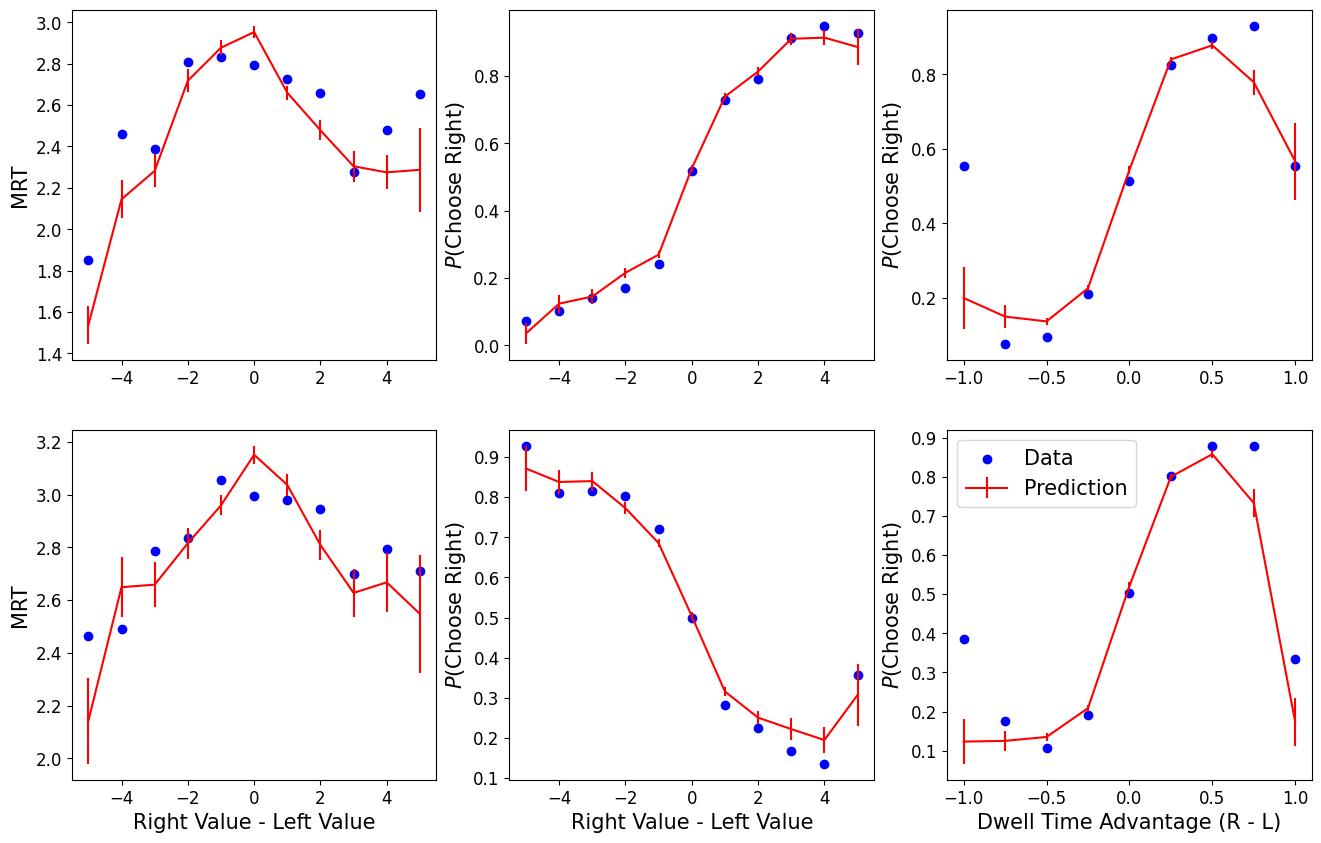

In [12]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.ylabel('MRT');

plt.subplot(232)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(233)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

###########
plt.subplot(234)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(235)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(236)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/sp2020_valuebased_complete_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

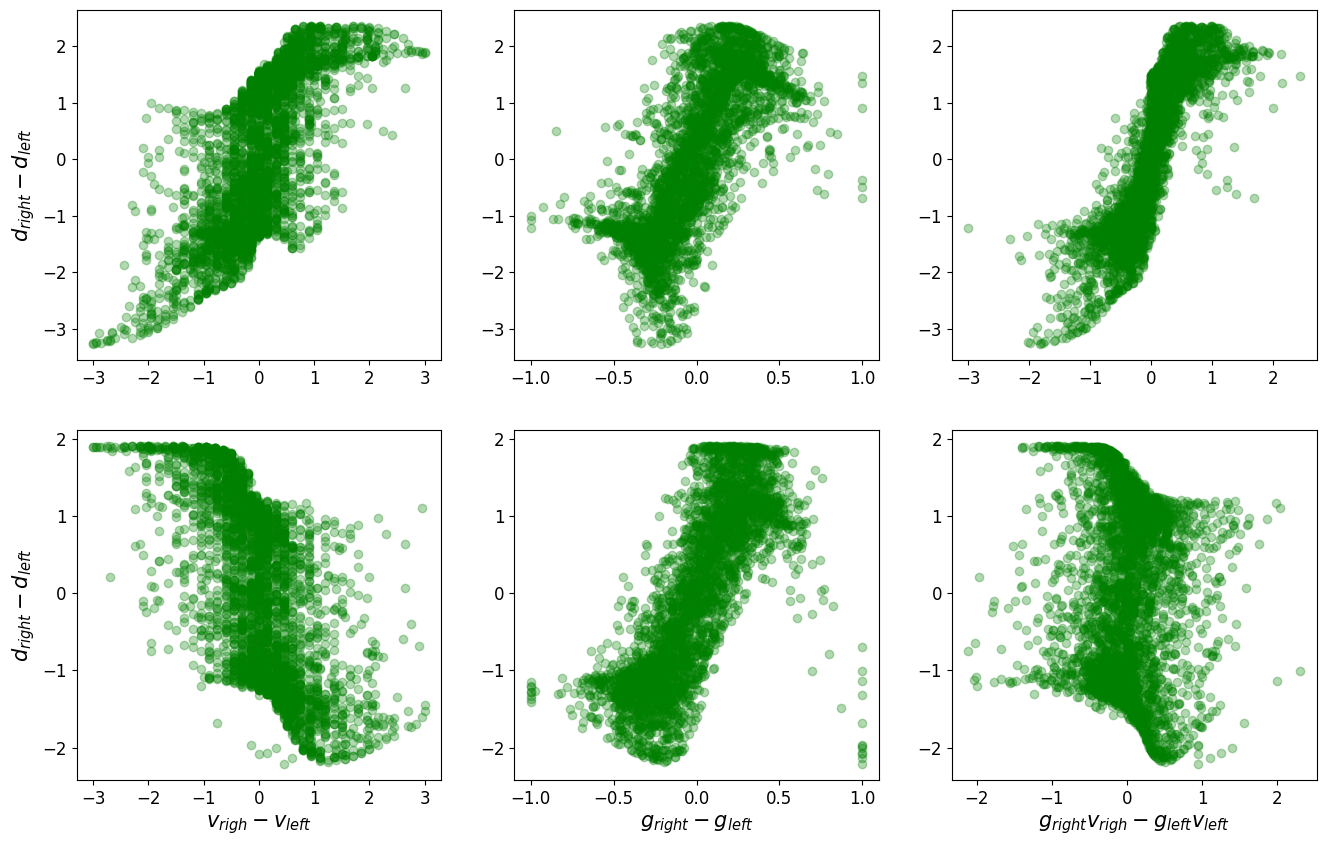

In [13]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_valuebased_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');